# Pryngles module: optics

Template of a module

## External modules

In [1]:
#@external
from pryngles import *
#@end:external

In [2]:
Scatterer_doc="""This is the basic class of a scatterer
"""

In [3]:
#@end:module

In [4]:
import pryngles.pixx as pixx
import time
pixx.rdfous_planet.__doc__

AttributeError: module 'pryngles.pixx' has no attribute 'rdfous_planet'

## Class: Scatterer

In [16]:
#@class
class Scatterer(PrynglesCommon):
    def __init__(self,
                 fname_planet: str = None,
                 fname_ring: str = None):
        """
        """
        self.save_values=[]
        
        self.data = None
        self.SPANGLER_SCATTERER_COLUMNS_UPDATE = ["name","x_obs","y_obs","z_obs","asp",
                                                  #Angles
                                                  "cos_luz","cos_obs","azim_obs_luz",
                                                  #State
                                                  "visible","shadow","indirect","emit","illuminated","transmit",
                                                  "hidden_by_luz","transit_over_luz","hidden_by_obs","transit_over_obs",
                                                  #Transit
                                                  "transit","occult",
                                                  #Physical properties
                                                  "albedo_gray_normal", "tau_gray_optical"]
        
        # Read scatter data,
        # !!! The filenames need to be less than 100 characters !!!
        self.read_data(fname_planet, fname_ring)
        
        # Set number of stokes elements that need to be calculated
        if fname_planet is None and fname_ring is None:
            self.nmatp = 1
            self.nmatr = 1
            self.nmat = 1
        elif fname_planet is None:
            self.nmatp = 1
            self.nmat = self.nmatr
        elif fname_ring is None:
            self.nmatr = 1
            self.nmat = self.nmatp
        else:
            self.nmat = np.max([self.nmatp,self.nmatr])
        
        # Output
        self.Stotp = np.zeros(self.nmatp)
        self.Ptotp = 0 
        self.Stotr = np.zeros(self.nmatr)
        self.Ptotr = 0 
        self.Stot = np.zeros(self.nmat)
        self.Ptot = 0
        
        # Add columns to dataframe
        if self.nmat == 4:
            if self.nmatr == 4:
                self.STOKES_VECTOR_RING = ["F","Q","U","V","P"]
            else:
                self.STOKES_VECTOR_RING = ["F","Q","U","P"]
            if self.nmatp == 4: 
                self.STOKES_VECTOR_PLANET = ["F","Q","U","V","P"]
            else:
                self.STOKES_VECTOR_PLANET = ["F","Q","U","P"]
            self.SPANGLER_SCATTERER_COLUMNS = ["beta_loc","F","Q","U","V","P"]
        elif self.nmat == 3:
            self.STOKES_VECTOR_RING = ["F","Q","U","P"]
            self.STOKES_VECTOR_PLANET = ["F","Q","U","P"]
            self.SPANGLER_SCATTERER_COLUMNS = ["beta_loc","F","Q","U","P"]
        elif self.nmat == 1:
            self.STOKES_VECTOR_RING = ["F"]
            self.STOKES_VECTOR_PLANET = ["F"]
            self.SPANGLER_SCATTERER_COLUMNS = ["beta_loc","F"]
        
    def read_data(self, 
                 fname_planet: str,
                 fname_ring: str):
        """
        Reads-in the fourier coefficients from the specified files
        Reading is by a FORTRAN function
        """
        if fname_planet is not None:
            i = j = 0
            with open(fname_planet) as file:
                for line in file: 
                    if line.rstrip()[0] != "#":
                        if i == 0:
                            nmatp = int(line.rstrip())
                        elif i ==1:
                            nmugsp = int(line.rstrip())
                        else:
                            j += 1
                        i += 1

            nfoup = int( (j-nmugsp)/(nmugsp**2) )
            
            self.nfoup = nfoup
            self.nmatp = nmatp
            self.nmugsp = nmugsp
            
            # Reflected light
            self.xmup,self.rfoup = pixx.rdfous_planet(fname_planet,nfoup,nmatp,nmugsp)
                        
        if fname_ring is not None:
            i = j = 0
            with open(fname_ring) as file:
                for line in file: 
                    if line.rstrip()[0] != "#":
                        if i == 0:
                            nmatr = int(line.rstrip())
                        elif i ==1:
                            nmugsr = int(line.rstrip())
                        else:
                            j += 1
                        i += 1

            nfour = int( (j-nmugsr)/(nmugsr**2) )
            
            self.nfour = nfour
            self.nmatr = nmatr
            self.nmugsr = nmugsr
            
            # Reflected light
            self.xmur,self.rfour = pixx.rdfous_ring(fname_ring,False,nfour,nmatr,nmugsr)
            
            # Transmitted light
            self.xmur,self.tfour = pixx.rdfous_ring(fname_ring,True,nfour,nmatr,nmugsr)
        
    def update_data(self,system):
        """
        Copies select data from the system object to a dataframe
        Adds the columns containing the beta angle, Stokes vector and degree of polarization
        """
        self.sys = system
        cond = system.sg.data.name != "Star"
        if self.data is None:
            self.data = deepcopy(system.sg.data.loc[cond,self.SPANGLER_SCATTERER_COLUMNS_UPDATE])
        else:
            self.data[self.SPANGLER_SCATTERER_COLUMNS_UPDATE] = \
                deepcopy(system.sg.data.loc[cond,self.SPANGLER_SCATTERER_COLUMNS_UPDATE])
        self.data[self.SPANGLER_SCATTERER_COLUMNS] = np.zeros((cond.sum(),len(self.SPANGLER_SCATTERER_COLUMNS)))
        
        # Reset output
        self.Stotp = np.zeros(self.nmatp)
        self.Ptotp = 0 
        self.Stotr = np.zeros(self.nmatr)
        self.Ptotr = 0 
        self.Stot = np.zeros(self.nmat)
        self.Ptot = 0
        
    def compute_angles(self):
        """
        Function that computes:
            - The phase angle
            - The azimuthal difference angle for every spangle
            - The beta angle for every spangle
        
        The beta angle rotates the local scattering plane to the planetary scattering plane
        """
        for name,body in self.sys.bodies.items():
            if body.kind == "Planet":
                center = body.center_ecl
                        
        azim,incli = Science.spherical(self.sys.n_obs)[1:]
        Rx = self.rotation_matrix_x(np.pi/2-incli)
        Rz = self.rotation_matrix_z(np.pi/2-azim)
        
        # Calculate normal vector and distance to star
        luz_ecl,self.d_luz = spy.unorm(center-self.sys.center_root)
        self.luz_obs = np.matmul(Rx, np.matmul(Rz, luz_ecl))
        
        self.phase_angle = np.dot(self.luz_obs,np.array([0,0,1]))
        
        for name,body in self.sys.bodies.items():
            if body.kind == "Star":
                verbose(VERB_SIMPLE,f"Body is a star... skipping")
                continue
                
            elif body.kind == "Planet":
                cond = self.data.name == body.kind
                etaps = self.data.loc[cond,"cos_luz"]
                zetaps =  self.data.loc[cond,"cos_obs"]
                
                # Azimuthal angle difference 
                t1 = self.phase_angle - zetaps*etaps
                t2 = np.sin(np.arccos(etaps))*np.sin(np.arccos(zetaps))
                t3 = t1/t2
                t3[t3 > 1] = 1.0
                t3[t3 < -1] = -1.0
                phidiffps = np.pi - np.arccos(t3)
                phidiffps[abs(t2) <= 1e-9] = 0.0 
                phidiffps[self.data.loc[cond, "y_obs"] < 0] *= -1
                self.data.loc[cond,"azim_obs_luz"] = phidiffps
                
                # Calculate beta angle
                x = self.data.loc[cond,"x_obs"]
                y = self.data.loc[cond,"y_obs"]
                if self.luz_obs[0] >= 0:
                    betaps = np.arctan(y/x)
                    betaps[x*y < 0] += np.pi
                else:
                    betaps = -np.arctan(y/x)
                    betaps[x*y >= 0] += np.pi
                self.data.loc[cond,"beta_loc"] = betaps
                
            elif body.kind == "Ring":
                cond = self.data.name == body.kind
                etars = self.data.loc[cond,"cos_luz"]
                zetars =  self.data.loc[cond,"cos_obs"]
                
                # Azimuthal angle difference 
                t1 = self.phase_angle - zetars*etars
                t2 = np.sin(np.arccos(etars))*np.sin(np.arccos(zetars))
                t3 = t1/t2
                t3[t3 > 1] = 1.0
                t3[t3 < -1] = -1.0
                phidiffrs = np.pi - np.arccos(t3)
                phidiffrs[abs(t2) <= 1e-9] = 0.0 
                self.data.loc[cond,"azim_obs_luz"] = phidiffrs
                
                # Beta calculation for rings
                t1 = etars - self.phase_angle*zetars
                t2 = np.sin(np.arccos(self.phase_angle))*np.sin(np.arccos(zetars))
                t3 = t1/t2
                t3[t3 > 1] = 1.0
                t3[t3 < -1] = -1.0
        
                if self.luz_obs[0] >= 0:
                    betars = np.arccos(t3)
                    betars[abs(t2) <= 1e-9] = 0.0 
                else:
                    betars = np.pi - np.arccos(t3)
                    betars[abs(t2) <= 1e-9] = 0.0 
                self.data.loc[cond,"beta_loc"] = betars
                
            else: 
                continue
    
    def scattering(self,
                   system,
                   normalize: bool = False):
        """
        Function that first updates the local dataframe with new geometry data
        Then computes the angles needed for the scattering code to work
        
        Checks which spangles are active and for which the scattered stokes vector needs to calculated
        Passes all the necessary angles and the fourier-coefficients file to a FORTRAN code 
        In the FORTRAN code the fourier coefficients are interpolated to the required angles
        and then summed to calculate the stokes vector.
        """
        # Update positional data
        self.update_data(system)
        
        # Calculate necessary angles
        self.compute_angles()

        angle_eps = 1e-3 # Value above which Cos(angle) needs to be
        rings_present = False
        
        #Planet
        for name,body in self.sys.bodies.items():
            if body.kind == "Star":
                verbose(VERB_SIMPLE,f"Body is a star... skipping")
                continue       
            elif body.kind == "Planet":
                condp = self.data.name == body.kind
                normp = 4*np.pi*body.radius**2
                if body.childs:
                    for bhash,child in body.childs.items():
                        if child.kind == "Ring":
                            rings_present = True
            elif body.kind == "Ring":
                condr = self.data.name == body.kind
                normr = 4*np.pi*(body.re**2 - body.ri**2)
        
        for name,body in self.sys.bodies.items():
            if body.kind == "Planet":
                # Spangles that are visible, illuminated and not in transit
                condv = (self.data.loc[condp,"visible"])&(self.data.loc[condp,"illuminated"])&\
                        (~self.data.loc[condp,"transit"])
                
                # Check if there are rings present
                if rings_present:
                    # Facets that are illuminated through the rings
                    condspr = (self.data.hidden_by_luz.apply(lambda x:"Ring" in x))&(self.data.visible)&\
                              (~self.data.loc[condp,"transit"])

                    # Facets that are visible but the line of sight is blocked by the rings
                    condspo = (self.data.hidden_by_obs.apply(lambda x:"Ring" in x))&(self.data.illuminated)&\
                              (~self.data.loc[condp,"transit"])
                    
                    cond = (condv) | (condspr) | (condspo)
                else:
                    cond = np.logical_and(condv,condp)
                
                # Only proceed if there are active spangles
                if cond.sum() > 0:
                    
                    self.data.loc[cond,self.STOKES_VECTOR_PLANET] = pixx.reflection(cond.sum(),
                                                                             self.data.loc[cond,"azim_obs_luz"], 
                                                                             self.data.loc[cond,"beta_loc"],
                                                                             abs(self.data.loc[cond,"cos_luz"]), 
                                                                             abs(self.data.loc[cond,"cos_obs"]),
                                                                             self.nmugsp,self.nmatp,self.nfoup,
                                                                             self.xmup,self.rfoup,
                                                                             self.data.loc[cond,"asp"]/normp)
                    
                    self.save_values+=[
                        dict(
                            obj="planet",
                            args=[
                                cond.sum(),
                                self.data.loc[cond,"azim_obs_luz"].values, 
                                self.data.loc[cond,"beta_loc"].values,
                                abs(self.data.loc[cond,"cos_luz"]).values, 
                                abs(self.data.loc[cond,"cos_obs"]).values,
                                self.nmugsp,self.nmatp,self.nfoup,
                                self.xmup,self.rfoup,
                                self.data.loc[cond,"asp"].values/normp,
                            ],
                            stokes=self.data.loc[cond,self.STOKES_VECTOR_PLANET].values,
                        )
                    ]

                    # Check if the rings are seen edge-on and/or illuminated edge-on
                    if rings_present:
                        vcheck = abs(self.data.loc[condr,"cos_obs"].iloc[0]) > angle_eps # seen
                        icheck = np.mean(abs(self.data.loc[condr,"cos_luz"])) > angle_eps # illuminated
                        vsum = condspo.sum()
                        isum = condspr.sum()
                        if vcheck and icheck and (vsum > 0) and (isum > 0):
                            self.data.loc[condspr,self.STOKES_VECTOR_PLANET[:-1]] *= \
                                        np.exp(-abs(np.mean(self.data.loc[condr,"tau_gray_optical"]/
                                                            self.data.loc[condr,"cos_luz"])))
                            self.data.loc[condspo,self.STOKES_VECTOR_PLANET[:-1]] *= \
                                        np.exp(-self.data.loc[condr,"tau_gray_optical"].iloc[0]/
                                                      abs(self.data.loc[condr,"cos_obs"].iloc[0]))
                        elif vcheck and (vsum > 0):
                            self.data.loc[condspo,self.STOKES_VECTOR_PLANET[:-1]] *= \
                                        np.exp(-self.data.loc[condr,"tau_gray_optical"].iloc[0]/
                                                      abs(self.data.loc[condr,"cos_obs"].iloc[0]))
                        elif icheck and (isum > 0):
                            self.data.loc[condspr,self.STOKES_VECTOR_PLANET[:-1]] *= \
                                        np.exp(-abs(np.mean(self.data.loc[condr,"tau_gray_optical"]/
                                                            self.data.loc[condr,"cos_luz"])))

                    Stotp = np.sum(self.data.loc[cond,self.STOKES_VECTOR_PLANET[:-1]],axis=0)
                    if Stotp[0] < 1e-6:
                        Ptotp = 0
                    elif abs(Stotp[2]) < 1e-6:
                        Ptotp = -Stotp[1]/Stotp[0]
                    else:
                        if self.nmatp == 4:
                            Ptotp = np.sqrt(Stotp[1]**2 + Stotp[2]**2 + Stotp[3]**2)/Stotp[0]
                        else:
                            Ptotp = np.sqrt(Stotp[1]**2 + Stotp[2]**2)/Stotp[0]
                    
                    # The normalized stokes vectors are given units
                    if not normalize:
                        self.data.loc[cond,self.STOKES_VECTOR_PLANET[:-1]] /= (4*np.pi*self.d_luz**2)*1e6 #ppm
                        self.data.loc[cond,self.STOKES_VECTOR_PLANET[:-1]] *= normp
                    
                        # Set integrated stokes vector
                        self.Stotp = Stotp/(4*np.pi*self.d_luz**2)*1e6*normp 
                    else:
                        self.data.loc[cond,self.STOKES_VECTOR_PLANET[:-1]] *= 4
                        self.Stotp = Stotp*4
                        
                    self.Ptotp = Ptotp  
                    
            elif body.kind == "Ring":
                # Spangles that are visible and illuminated
                condv = (self.data.loc[condr,"visible"])&(self.data.loc[condr,"illuminated"])

                # Check if there is transmission through the ring
                transmission = False 
                if (np.mean(self.data.loc[condr,"cos_luz"]) < 0) ^ (self.data.loc[condr,"cos_obs"].iloc[0] < 0):
                    transmission = True

                # Make sure the dimensions are correct
                cond = np.logical_and(condv,condr)

                if cond.sum() > 0:                    
                    if transmission:
                        self.data.loc[cond,self.STOKES_VECTOR_RING] = pixx.reflection(cond.sum(),
                                                                               self.data.loc[cond,"azim_obs_luz"], 
                                                                               self.data.loc[cond,"beta_loc"],
                                                                               abs(self.data.loc[cond,"cos_luz"]), 
                                                                               abs(self.data.loc[cond,"cos_obs"]),
                                                                               self.nmugsr,self.nmatr,self.nfour,
                                                                               self.xmur,self.tfour,
                                                                               self.data.loc[cond,"asp"]/normr)
                        self.save_values+=[
                            dict(
                                obj="planet",
                                args=[
                                    cond.sum(),
                                    self.data.loc[cond,"azim_obs_luz"].values, 
                                    self.data.loc[cond,"beta_loc"].values,
                                    abs(self.data.loc[cond,"cos_luz"]).values, 
                                    abs(self.data.loc[cond,"cos_obs"]).values,
                                    self.nmugsr,self.nmatr,self.nfour,
                                    self.xmur,self.tfour,
                                    self.data.loc[cond,"asp"].values/normr
                                ],
                                stokes=self.data.loc[cond,self.STOKES_VECTOR_PLANET].values,
                            )
                        ]
                        
                    else:
                        self.data.loc[cond,self.STOKES_VECTOR_RING] = pixx.reflection(cond.sum(),
                                                                               self.data.loc[cond,"azim_obs_luz"], 
                                                                               self.data.loc[cond,"beta_loc"],
                                                                               abs(self.data.loc[cond,"cos_luz"]), 
                                                                               abs(self.data.loc[cond,"cos_obs"]),
                                                                               self.nmugsr,self.nmatr,self.nfour,
                                                                               self.xmur,self.rfour,
                                                                               self.data.loc[cond,"asp"]/normr)
                        
                        self.save_values+=[
                            dict(
                                obj="planet",
                                args=[
                                       cond.sum(),
                                       self.data.loc[cond,"azim_obs_luz"].values, 
                                       self.data.loc[cond,"beta_loc"].values,
                                       abs(self.data.loc[cond,"cos_luz"]).values, 
                                       abs(self.data.loc[cond,"cos_obs"]).values,
                                       self.nmugsr,self.nmatr,self.nfour,
                                       self.xmur,self.rfour,
                                       self.data.loc[cond,"asp"].values/normr
                                ],
                                stokes=self.data.loc[cond,self.STOKES_VECTOR_PLANET].values,
                            )
                        ]

                    Stotr = np.sum(self.data.loc[cond,self.STOKES_VECTOR_RING[:-1]],axis=0)
                    if Stotr[0] < 1e-6:
                        Ptotr = 0
                    elif abs(Stotr[2]) < 1e-6:
                        Ptotr = -Stotr[1]/Stotr[0]
                    else:
                        if self.nmatr == 4:
                            Ptotr = np.sqrt(Stotr[1]**2 + Stotr[2]**2 + Stotr[3]**2)/Stotr[0]
                        else:
                            Ptotr = np.sqrt(Stotr[1]**2 + Stotr[2]**2)/Stotr[0]
                    # The normalized stokes vectors are given units
                    if not normalize:
                        self.data.loc[cond,self.STOKES_VECTOR_RING[:-1]] /= (4*np.pi*self.d_luz**2)*1e6 #ppm
                        self.data.loc[cond,self.STOKES_VECTOR_RING[:-1]] *= normr
                        
                        # Set integrated stokes vector
                        self.Stotr = Stotr/(4*np.pi*self.d_luz**2)*1e6*normr 
                    else:
                        self.data.loc[cond,self.STOKES_VECTOR_RING[:-1]] *= 4
                        self.Stotr = Stotr*4
                        
                    self.Ptotr = Ptotr
            else:
                continue
                
        # Calculate total flux and total degree of polarization
        if self.nmat > 1:            
            Stot = np.sum(self.data.loc[:,self.SPANGLER_SCATTERER_COLUMNS[1:-1]],axis=0)
            if abs(Stot[2]) < 1e-18:
                Ptot = -Stot[1]/Stot[0]
            else:
                if self.nmatr == 4:
                    Ptot = np.sqrt(Stot[1]**2 + Stot[2]**2 + Stot[3]**2)/Stot[0]
                else:
                    Ptot = np.sqrt(Stot[1]**2 + Stot[2]**2)/Stot[0]
            self.Stot = Stot
            self.Ptot = Ptot
        else:
            self.Stot = self.Stotp + self.Stotr
            self.Ptot = 0
            
        output_dict = {"Stot": self.Stot, "Ptot": self.Ptot, "Stotp": self.Stotp,
                       "Ptotp": self.Ptotp, "Stotr": self.Stotr, "Ptotr": self.Ptotr}
        return output_dict

    def rotation_matrix_x(self,angle):
        """
        Rotation matrix for a rotation around the x-axis
        """
        Rm = np.array([[1,0,0],[0,np.cos(angle), np.sin(angle)],[0,-np.sin(angle),np.cos(angle)]])
        return Rm
    
    def rotation_matrix_z(self,angle):
        """
        Rotation matrix for a rotation around the z-axis
        """
        Rm = np.array([[np.cos(angle), -np.sin(angle),0],[np.sin(angle),np.cos(angle),0],[0,0,1]])
        return Rm
        
    def orbital_rotation_rate(self):
        """
        Calculate the orbital rotation rate of a circular orbit
        Used in converting the integration time to degrees of true anomaly
        """
        for name,body in self.sys.bodies.items():
            if name == "Star":
                ms = body.m
            elif name == "Planet":
                a = body.a
                mp = body.m
                
        n = 1/np.sqrt(a**3/(self.sys.G*(ms+mp)))
        return n
    
    def lambertian_test(self,alpha):
        """
        Simple, analytical model for the normalized reflected light coming of a lambertian planet
        """
        F = 2*(np.sin(alpha)+(np.pi-alpha)*np.cos(alpha))/3
        return F
        
Scatterer.__doc__=Scatterer_doc
#@end:class

In [4]:
#@test:optics
def test_scatterer(self):
    Verbose.VERBOSITY=VERB_NONE
    
    au = 1.496e+11
    sys=System(units=["au","msun","yr"])
    S=sys.add(radius=Consts.rsun/au)
    P=sys.add("Planet",primary=S,radius=Consts.rsaturn/au,a=3,nspangles=1000)
    sys.initialize_simulation()
    sys.spangle_system()

    incli = 0
    azim = 179
    sys.update_perspective(n_obs=Science.direction(azim,incli))
    
    # Test Scatterer class
    test = Scatterer(fname_planet="./data/fou_lambert.dat",fname_ring=None)
    out_dict = test.scattering(sys,normalize=True)
    F = test.lambertian_test(np.arccos(test.phase_angle))/np.pi
    print("Flux from pryngles: ", out_dict["Stot"][0])
    print("Flux from theory: ", F)

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_scatterer=test_scatterer
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

/tmp/ipykernel_5580/3478680527.py:186: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.data.loc[cond,"azim_obs_luz"] = phidiffps
.
----------------------------------------------------------------------
Ran 1 test in 1.083s

OK


Flux from pryngles:  0.6624944164436892
Flux from theory:  0.6665655061636937


## Playing ground

<IPython.core.display.Javascript object>


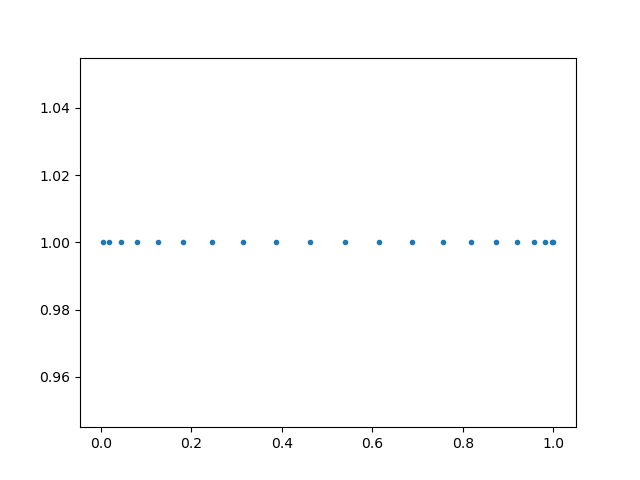

In [6]:
# Gaussian absiccae
a = np.array([0.34357004E-02,
  0.18014036E-01,
  0.43882786E-01,
  0.80441514E-01,
  0.12683405E+00,
  0.18197316E+00,
  0.24456650E+00,
  0.31314696E+00,
  0.38610707E+00,
  0.46173674E+00,
  0.53826326E+00,
  0.61389293E+00,
  0.68685304E+00,
  0.75543350E+00,
  0.81802684E+00,
  0.87316595E+00,
  0.91955849E+00,
  0.95611721E+00,
  0.98198596E+00,
  0.99656430E+00,
  0.10000000E+01])
fig = plt.figure()
plt.plot(a,np.ones_like(a), ".")
plt.show()

<IPython.core.display.Javascript object>


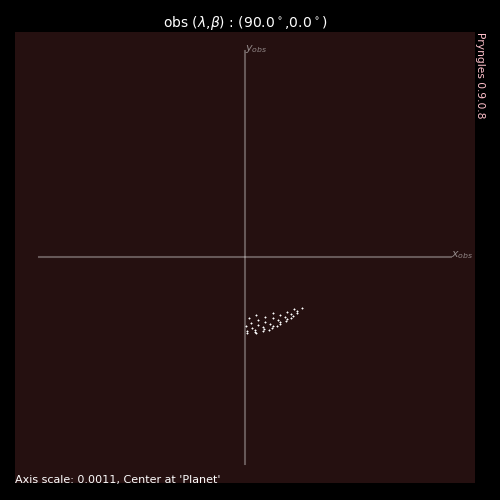

In [7]:
au = 1.496e+11
units=['au','msun','yr']
sys = System(units=units)
S=sys.add(radius=Consts.rsun/au, m = 1)
P=sys.add("Planet",primary=S,radius=Consts.rsaturn/au,a=3, m=2.8e-4)
R=sys.add("Ring",primary=P,
          fi=1.5, fe=2.25,
          i=30*Consts.deg,roll=90*Consts.deg,
          tau_gray_optical = 0.4)
sys.initialize_simulation()
sys.spangle_system()

incli = 0
azim = 90
sys.update_perspective(n_obs=Science.direction(azim,incli))
spangle_size_multi = 200
sys.sg.data.dsp *= spangle_size_multi

cond=(sys.sg.data.hidden_by_luz.apply(lambda x:'Ring' in x))&(sys.sg.data.visible)&\
     (~sys.sg.data.loc[sys.sg.data.name=="Planet","transit"])
cond1=(sys.sg.data.hidden_by_obs.apply(lambda x:'Ring' in x))&(sys.sg.data.illuminated)&\
      (~sys.sg.data.loc[sys.sg.data.name=="Planet","transit"])
cond += cond1

sys.sg.plot2d(include=["Planet", "Ring"],show_azim=False,highlight=(cond,dict()))
sys.sg.data.dsp /= spangle_size_multi

In [8]:
test = Scatterer(fname_planet="./data/fou_gasplanet.dat",fname_ring="./data/fou_ring_0_4_0_8.dat")

st = time.time()
out_dict = test.scattering(sys,normalize=True)
et = time.time()
print("Time total: ", et-st)

F = test.lambertian_test(np.arccos(test.phase_angle))/np.pi
print("Theoretical F: ",F)
# print(sys.data)
print("Phase angle: ", np.arccos(test.phase_angle)*180/np.pi)

Time total:  0.13120126724243164
Theoretical F:  0.21220659078919377
Phase angle:  90.0


<IPython.core.display.Javascript object>


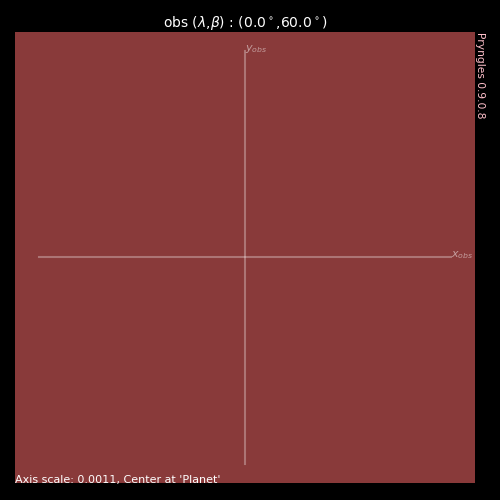

In [9]:
au = 1.496e+11
units=['au','msun','yr']
sys = System(units=units)
S=sys.add(radius=Consts.rsun/sys.ul, m = 1)
P=sys.add("Planet",primary=S, radius=Consts.rsaturn/sys.ul, 
          a=3, m=2.8e-4, nspangles=1000)
R=sys.add("Ring",primary=P,
          fi=1.5, fe=2.25,
          i=-30*Consts.deg,roll=0*Consts.deg,
          nspangles=1000,
          tau_gray_optical = 0.4)
sys.initialize_simulation()
sys.spangle_system()

azim = 0
incli = 60
sys.update_perspective(n_obs=Science.direction(azim,incli))
spangle_size_multi = 200
sys.sg.data.dsp *= spangle_size_multi
sys.sg.plot2d(include=["Planet","Ring"])
sys.sg.data.dsp /= spangle_size_multi

In [11]:
sys.sg.data.loc[sys.sg.data.name == "Ring", "tau_gray_optical"] = 0.4
sys.sg.data.loc[sys.sg.data.name == "Ring", "tau_gray_optical"]

1974    0.4
1975    0.4
1976    0.4
1977    0.4
1978    0.4
       ... 
3013    0.4
3014    0.4
3015    0.4
3016    0.4
3017    0.4
Name: tau_gray_optical, Length: 1044, dtype: float64

In [22]:
import time
test = Scatterer(fname_planet="./data/fou_gasplanet.dat",fname_ring="./data/fou_ring_0_4_0_8.dat")

# Translate years to degrees for a circular orbit
test.update_data(sys)
n = test.orbital_rotation_rate()
nu0 = 0*Consts.deg
nu = 360*Consts.deg
nstep = 181
step = ((nu-nu0)/nstep)/n
steps = np.linspace(nu0*step,nstep*step,nstep)

# Save arrays
Fp = []
Pp = []
Fr = []
Pr = []
P = []
alpha = []
make_plot = False

for step in steps:
    st = time.time()
    sys.integrate(step)
    sys.update_perspective()
    et = time.time()
    print("Geometry time: ",et-st)
    
    st = time.time()
    out_dict = test.scattering(sys)
    et = time.time()
    print("Scattering time: ",et-st)
    
    print("True anomaly: ",step*Consts.rad*n,"Phase angle: ",np.arccos(test.phase_angle)*Consts.rad,
          "\n F planet: ", out_dict["Stotp"][0],"P planet: ", out_dict["Ptotp"],
          "F ring: ", out_dict["Stotr"][0], "P Ring: ", out_dict["Ptotr"])
    Fp += [out_dict["Stotp"][0]]
    Pp += [out_dict["Ptotp"]]
    Fr += [out_dict["Stotr"][0]]
    Pr += [out_dict["Ptotr"]]
    P += [out_dict["Ptot"]]
    alpha += [np.arccos(test.phase_angle)*Consts.rad]
    
#     if step*Consts.rad*n%20 < 1:
#         sys.sg.data.dsp *= spangle_size_multi
#         sys.sg.plot2d(include=["Planet","Ring"])
#         sys.sg.data.dsp /= spangle_size_multi

Fp = np.array(Fp)
Pp = np.array(Pp)
Fr = np.array(Fr)
Pr = np.array(Pr)
P = np.array(P)

Geometry time:  0.810286283493042
Scattering time:  0.15662646293640137
True anomaly:  0.0 Phase angle:  120.00000000000001 
 F planet:  0.0003339141864083577 P planet:  0.15176835005234435 F ring:  0.0006863279032292073 P Ring:  0.04598250836631771
Geometry time:  0.6818697452545166
Scattering time:  0.14722084999084473
True anomaly:  2.0000000000000004 Phase angle:  119.97986203936273 
 F planet:  0.0003341024376625879 P planet:  0.15190684913904592 F ring:  0.0006850508813760011 P Ring:  0.04601357002693921
Geometry time:  0.6727831363677979
Scattering time:  0.14748311042785645
True anomaly:  4.000000000000001 Phase angle:  119.91949710800908 
 F planet:  0.0003348204014900092 P planet:  0.15215234389282098 F ring:  0.0006841187281569008 P Ring:  0.04612663957722473
Geometry time:  0.6719729900360107
Scattering time:  0.14720678329467773
True anomaly:  6.000000000000001 Phase angle:  119.81905158300643 
 F planet:  0.00033605720580092633 P planet:  0.15242451620720868 F ring:  0.00

Geometry time:  0.7118790149688721
Scattering time:  0.14962124824523926
True anomaly:  64.00000000000001 Phase angle:  102.6678426193663 
 F planet:  0.00056619230586168 P planet:  0.18774266972575737 F ring:  0.00026786263258886655 P Ring:  0.07602529858011178
Geometry time:  0.6937408447265625
Scattering time:  0.13579344749450684
True anomaly:  66.00000000000001 Phase angle:  101.74083498456214 
 F planet:  0.0005801162350519565 P planet:  0.1879215247852054 F ring:  0.0002501826303844865 P Ring:  0.0775173620077644
Geometry time:  0.6809446811676025
Scattering time:  0.1381669044494629
True anomaly:  68.00000000000001 Phase angle:  100.80246831443904 
 F planet:  0.0005989506584128909 P planet:  0.18903541640016855 F ring:  0.00023219839139332433 P Ring:  0.07899484033646836
Geometry time:  0.6763722896575928
Scattering time:  0.1357862949371338
True anomaly:  70.00000000000001 Phase angle:  99.85373996668753 
 F planet:  0.0006105809346702458 P planet:  0.18859391658818173 F ring

Geometry time:  0.6780948638916016
Scattering time:  0.13955378532409668
True anomaly:  128.00000000000003 Phase angle:  72.07668727829972 
 F planet:  0.000983885322059124 P planet:  0.12538652670942643 F ring:  0.00017445135382681987 P Ring:  0.08484708980823498
Geometry time:  0.6812276840209961
Scattering time:  0.14079952239990234
True anomaly:  130.00000000000003 Phase angle:  71.25773490113797 
 F planet:  0.0010158657477175059 P planet:  0.12056266753238519 F ring:  0.00017655637448048373 P Ring:  0.08392506013855597
Geometry time:  0.6936447620391846
Scattering time:  0.1412818431854248
True anomaly:  132.00000000000003 Phase angle:  70.45859565682815 
 F planet:  0.0010133183485071012 P planet:  0.11359488162651026 F ring:  0.00017649852030522485 P Ring:  0.08317144762052402
Geometry time:  0.6907711029052734
Scattering time:  0.14252543449401855
True anomaly:  134.00000000000003 Phase angle:  69.68038456917965 
 F planet:  0.0010210453635251858 P planet:  0.11079458996277741

Geometry time:  0.6789553165435791
Scattering time:  0.15507054328918457
True anomaly:  192.00000000000003 Phase angle:  60.7206743698087 
 F planet:  0.0013221137518909004 P planet:  0.10062163626762936 F ring:  0.00024627557159298443 P Ring:  0.0480089345144912
Geometry time:  0.6844332218170166
Scattering time:  0.15537619590759277
True anomaly:  194.00000000000003 Phase angle:  60.97837664232428 
 F planet:  0.0013059122951307456 P planet:  0.1005300931763771 F ring:  0.0002472073774971765 P Ring:  0.0483325233917711
Geometry time:  0.6901884078979492
Scattering time:  0.1545569896697998
True anomaly:  196.00000000000003 Phase angle:  61.274083451433015 
 F planet:  0.0012916123828168899 P planet:  0.10110450249439532 F ring:  0.0002477902309645953 P Ring:  0.048759638564245956
Geometry time:  0.6828250885009766
Scattering time:  0.1534714698791504
True anomaly:  198.00000000000003 Phase angle:  61.60712063334549 
 F planet:  0.0012746410310952843 P planet:  0.10138309032608522 F r

Geometry time:  0.6961991786956787
Scattering time:  0.13646531105041504
True anomaly:  256.00000000000006 Phase angle:  83.06004368113106 
 F planet:  0.0008849065130198463 P planet:  0.16979002847447072 F ring:  0.0001032540643498845 P Ring:  0.09298195265216135
Geometry time:  0.6923136711120605
Scattering time:  0.13524103164672852
True anomaly:  258.00000000000006 Phase angle:  84.04070540246006 
 F planet:  0.0008701220028658254 P planet:  0.17207199981135105 F ring:  9.049103699879664e-05 P Ring:  0.09263778669729301
Geometry time:  0.7020983695983887
Scattering time:  0.13559722900390625
True anomaly:  260.00000000000006 Phase angle:  85.02688422457047 
 F planet:  0.0008650507878807203 P planet:  0.17403508174933846 F ring:  7.682557176444694e-05 P Ring:  0.09214141018268593
Geometry time:  0.6827399730682373
Scattering time:  0.13486719131469727
True anomaly:  262.00000000000006 Phase angle:  86.01764518014285 
 F planet:  0.0008674026731676741 P planet:  0.17581850529672732 

Geometry time:  0.6861622333526611
Scattering time:  0.14127492904663086
True anomaly:  318.00000000000006 Phase angle:  111.81649205810683 
 F planet:  0.0004433910242194876 P planet:  0.17411913671517923 F ring:  0.0004490245043216974 P Ring:  0.06058537045672963
Geometry time:  0.6841092109680176
Scattering time:  0.14210057258605957
True anomaly:  320.00000000000006 Phase angle:  112.52459887746214 
 F planet:  0.00043334400232315507 P planet:  0.17244025222184373 F ring:  0.00046454294427309995 P Ring:  0.059343930598953605
Geometry time:  0.7152631282806396
Scattering time:  0.1416621208190918
True anomaly:  322.0 Phase angle:  113.20726335480579 
 F planet:  0.00042406539034659196 P planet:  0.1706366481102987 F ring:  0.00047986441199509113 P Ring:  0.05814098596932259
Geometry time:  0.7188522815704346
Scattering time:  0.14322400093078613
True anomaly:  324.0 Phase angle:  113.86336003786516 
 F planet:  0.0004148486030312518 P planet:  0.16909694697575628 F ring:  0.00049631

In [19]:
import pickle

In [23]:
f=open("reflection-test.pkl","wb")
pickle.dump(test.save_values,f)

In [21]:
test.save_values

[{'obj': 'planet',
  'args': [164,
   array([-1.0468917895905396, -1.0447899014855664, -1.0344618101028833,
          -1.0350963745375594, -1.01547129399829, -1.0094336296179223,
          -0.992143730128745, -0.9840122275189445, -1.017771175191756,
          -1.0107962177159822, -0.96228940723464, -0.9797787467381549,
          -0.9785654286523595, -0.9418558411573708, -0.921898260472902,
          -0.9875487454615035, -1.014162098512037, -0.9409988594909864,
          -0.9402800723701801, -0.865696637958083, -1.0076479177728919,
          -0.9727478158492522, -0.8868069766590692, -0.894703580240952,
          -0.948591764800176, -0.8100208089436776, -0.787427337759242,
          -0.9273166185903472, -0.8898342807607169, -0.8355075907300904,
          -0.9672384741303008, -0.9734678223948707, -0.8179241502628849,
          -0.6811269882202065, -0.8748915033638269, -0.8999832906026577,
          -0.7141038720820205, -0.7588672126846907, -0.9196209416566288,
          -0.827515796466399

<IPython.core.display.Javascript object>


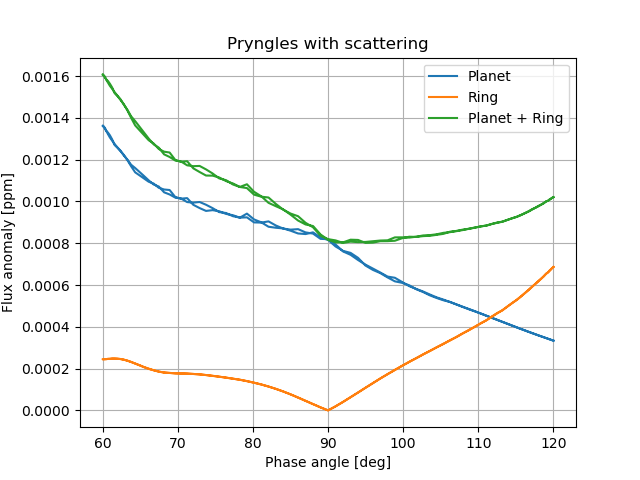

<IPython.core.display.Javascript object>


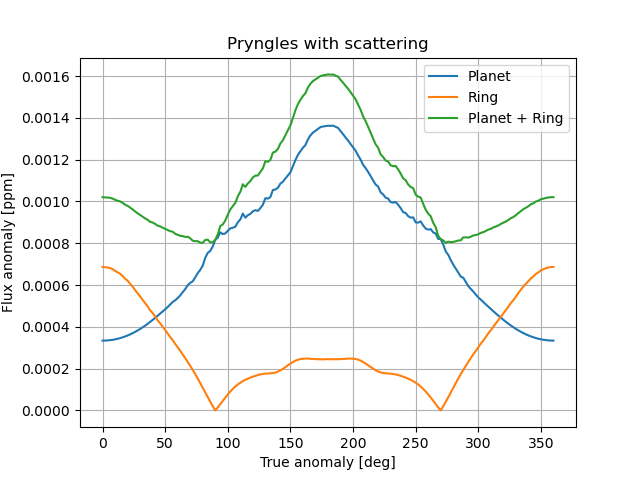

<IPython.core.display.Javascript object>


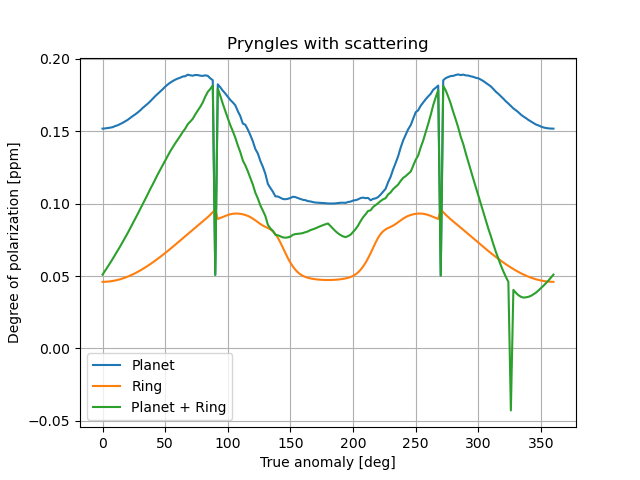

In [23]:
import matplotlib.pyplot as plt
n = test.orbital_rotation_rate()
nu0 = 0*Consts.deg
nu = 360*Consts.deg
nstep = 181
step = ((nu-nu0)/nstep)/n
steps = np.linspace(nu0*step,nstep*step,nstep)
steps = steps*Consts.rad*n

fig=plt.figure()
ax=fig.gca()
ax.plot(alpha,Fp,label="Planet")
ax.plot(alpha,Fr,label="Ring")
ax.plot(alpha,Fp+Fr,label="Planet + Ring")
ax.set_xlabel("Phase angle [deg]")
ax.set_ylabel("Flux anomaly [ppm]")
ax.set_title("Pryngles with scattering")
ax.legend();
ax.grid()
plt.show()

fig=plt.figure()
ax=fig.gca()
ax.plot(steps,Fp,label="Planet")
ax.plot(steps,Fr,label="Ring")
ax.plot(steps,Fp+Fr,label="Planet + Ring")
ax.set_xlabel("True anomaly [deg]")
ax.set_ylabel("Flux anomaly [ppm]")
ax.set_title("Pryngles with scattering")
ax.legend();
ax.grid()
plt.show()

fig=plt.figure()
ax=fig.gca()
ax.plot(steps,Pp,label="Planet")
ax.plot(steps,Pr,label="Ring")
ax.plot(steps,P,label="Planet + Ring")
ax.set_xlabel("True anomaly [deg]")
ax.set_ylabel("Degree of polarization [ppm]")
ax.set_title("Pryngles with scattering")
ax.legend();
ax.grid()
plt.show()

# Re-check

In [ ]:
print(sys.sg.data[sys.sg.data.name=="Planet"].azim_obs - sys.sg.data[sys.sg.data.name=="Planet"].azim_luz)
print(test.data[test.data.name=="Planet"].azim_obs_luz)